In [302]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
#from fancyimpute import KNN, IterativeImputer 

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

train_path = "res/CongressionalVotingID.shuf.train.csv"
test_path = "res/CongressionalVotingID.shuf.test.csv"
result_folder = "results/"

test_set_ratio = 0.1 

In [303]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
ids=df_train.pop("ID")
ids=df_test.pop("ID")
df_train = df_train.replace({'y':True, 'n':False, 'unknown':np.nan})
df_test = df_test.replace({'y':True, 'n':False, 'unknown':np.nan})
#df_train.head(20)
df_test.head(20)

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,True,True,True,False,True,True,True,True,False,True,True,False,False,False,True,NaN
1,False,True,False,True,True,True,False,False,False,False,False,True,NaN,NaN,False,NaN
2,True,False,True,False,False,False,True,False,True,True,True,False,False,False,True,True
3,False,True,False,True,True,True,False,False,False,False,False,True,True,True,False,True
4,False,False,True,False,False,True,True,True,True,True,True,False,False,False,NaN,True
5,True,True,True,False,False,False,True,True,True,False,False,False,False,False,NaN,NaN
6,False,NaN,True,False,False,True,True,True,True,True,False,False,False,True,True,True
7,True,False,True,False,False,False,True,True,True,False,False,False,False,False,True,NaN
8,True,True,True,False,False,False,True,True,False,True,False,False,False,False,False,True
9,False,NaN,False,True,True,True,False,False,False,False,False,True,True,True,False,True


### Initialize Training data

In [299]:
df_vars = df_train.loc[:, df_train.columns != 'class']
df_class = df_train['class']
#df_test=df_test.loc[:, df_test.columns == 'physician-fee-freeze']
# impute nans

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_vars)

df_vars = imp.transform(df_vars)
imp.fit(df_test)
df_test = imp.transform(df_test)
#df_vars = SelectKBest(chi2, k=2).fit_transform(df_vars, df_class)
#df_vars = IterativeImputer().fit_transform(df_vars)
#df_test = IterativeImputer().fit_transform(df_test)
#clf = NearestCentroid(metric="euclidean")
clf=LinearSVC(dual=False)
#df_test = SelectKBest(chi2, k=1).fit_transform(df_test, df_class)
#df_test = SelectKBest(chi2, k=1).fit_transform(df_vars_all, df_class)
X_train, X_test, y_train, y_test = train_test_split(df_vars, df_class, test_size=.2, random_state=3124132)
#clf = RandomForestClassifier(n_estimators=100, max_features=1)
#
#clf = SVC(kernel='linear', random_state=123093234)
#clf = GaussianNB()

### Simple cross validation for well-founded results

In [300]:
scores = cross_validate(clf, df_vars, df_class, cv=10)
scores['test_score']

array([0.86956522, 0.95454545, 0.95454545, 1.        , 1.        ,
       0.95454545, 1.        , 0.95238095, 1.        , 1.        ])

### Model fitting and sample testing

In [293]:
model = clf.fit(X_train, y_train)
model.score(X_test, y_test)

1.0

### Final prediction

In [200]:
df_res = pd.DataFrame()
df_res['ID'] = ids.astype(int)
df_res['class'] = pd.Series(model.predict(df_test))
df_res.head(10)

,ID,class
0,368,democrat
1,15,republican
2,94,democrat
3,107,republican
4,285,democrat
5,53,democrat
6,138,democrat
7,265,democrat
8,419,democrat
9,226,republican


### Export

In [201]:

export_file_name = result_folder + "congress_1feature_nearestcentroid.csv"
df_res.to_csv(export_file_name, index=False)


### Easy comparison

In [32]:
import traceback
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid

df_vars = df_train.loc[:, df_train.columns != 'class']
df_class = df_train['class']

df_vars = IterativeImputer().fit_transform(df_vars)

names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]

classifiers = [
    NearestCentroid(),
    SVC(kernel="linear"),
    DecisionTreeClassifier(),
    GaussianNB()]

cl_scores = {}

for name, clf in zip(names, classifiers):
    try:
        np.random.seed(32143421)
        scores = cross_validate(clf, df_vars, df_class, cv=10, scoring='accuracy', return_train_score=True)
        cl_scores[name] = scores
        print(name,"-- Training Set --", "Mean", scores['train_score'].mean(), "-- Min", scores['train_score'].min(), "-- Max", scores['train_score'].max())
        print(name,"-- Test Set --", "Mean", scores['test_score'].mean(), "-- Min", scores['test_score'].min(), "-- Max", scores['test_score'].max())
    except:
        print("Classification failed for", name)
        traceback.print_exc()

NameError: name 'IterativeImputer' is not defined

In [305]:
import traceback
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid

df_vars = df_train.loc[:, df_train.columns != 'class']
df_class = df_train['class']

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_vars)
df_vars = imp.transform(df_vars)
df_vars = SelectKBest(chi2, k=2).fit_transform(df_vars_all, df_class)
names = ["Euclidian", "Manhattan",
         "Chebyshev", "Minkowski"]
scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro'}
classifiers = [
    NearestCentroid(metric="euclidean"),
    NearestCentroid(metric="manhattan"),
    NearestCentroid(metric="chebyshev"),
    NearestCentroid(metric="minkowski")]

cl_scores = {}

for name, clf in zip(names, classifiers):
    try:
        np.random.seed(32143421)
        scores = cross_validate(clf, df_vars, df_class, cv=10, scoring=scoring, return_train_score=True)
        cl_scores[name] = scores
        print(name,"-- Training Set --", "Mean", scores['train_acc'].mean())
        print(name,"-- Test Set --", "Mean", scores['test_acc'].mean())
        print(name,"-- Training Set --", "Mean Precision", scores['train_prec'].mean())
        print(name,"-- Test Set --", "Mean Precision", scores['test_prec'].mean())
        print(name,"-- Training Set --", "Mean Recall", scores['train_rec'].mean())
        print(name,"-- Test Set --", "Mean Recall", scores['test_rec'].mean())
    except:
        print("Classification failed for", name)
        traceback.print_exc()
    

Euclidian -- Training Set -- Mean 0.9633039682096971
Euclidian -- Test Set -- Mean 0.9634010916619612
Euclidian -- Training Set -- Mean Precision 0.9572317742928522
Euclidian -- Test Set -- Mean Precision 0.9605982905982906
Euclidian -- Training Set -- Mean Recall 0.9657629525643465
Euclidian -- Test Set -- Mean Recall 0.9662164224664224
Manhattan -- Training Set -- Mean 0.9449598503985742
Manhattan -- Test Set -- Mean 0.9454169019386411
Manhattan -- Training Set -- Mean Precision 0.9485628432733308
Manhattan -- Test Set -- Mean Precision 0.9509920634920634
Manhattan -- Training Set -- Mean Recall 0.9335045736946543
Manhattan -- Test Set -- Mean Recall 0.934149877899878
Chebyshev -- Training Set -- Mean 0.9633039682096971
Chebyshev -- Test Set -- Mean 0.9634010916619612
Chebyshev -- Training Set -- Mean Precision 0.9572317742928522
Chebyshev -- Test Set -- Mean Precision 0.9605982905982906
Chebyshev -- Training Set -- Mean Recall 0.9657629525643465
Chebyshev -- Test Set -- Mean Recall 

C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\neighbors\nearest_centroid.py:141: UserWarning:

Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.

C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\neighbors\nearest_centroid.py:141: UserWarning:

Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.

C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\neighbors\nearest_centroid.py:141: UserWarning:

Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.

C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\neighbors\nearest_centroid.py:141: UserWarning:

Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.

C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\neighbors\nearest_centroid.py:141: UserWarning:

Averaging for metrics other than euclidean and manhattan n

In [73]:
import traceback
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate


#df_vars = df_vars_all.drop('win', axis=1)


df_vars_all = df_train.loc[:, df_train.columns != 'class']
df_class = df_train['class']

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_vars)
df_vars_all = imp.transform(df_vars)


#X_train, X_test, y_train, y_test = train_test_split(df_vars_all, df_class, test_size=test_set_ratio, random_state=0)

names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]
scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro'}
classifiers = [
    NearestCentroid(metric="euclidean"),
    LinearSVC(dual=False),
    DecisionTreeClassifier(),
    GaussianNB()]


cl_scores = {}
for name in names:
    cl_scores[name] = []
    
for feature_count in [2]:
    if feature_count != 0:
        df_vars = SelectKBest(chi2, k=feature_count).fit_transform(df_vars_all, df_class)
    else:
        df_vars = df_vars_all
    print("-"*60)
    print("Feature count=", feature_count if feature_count > 0 else "ALL")
    for name, clf in zip(names, classifiers):
        try:
            np.random.seed(32143421)
            scores = cross_validate(clf, df_vars, df_class, cv=10, scoring=scoring,return_train_score=True)
            cl_scores[name].append(scores)
            print(name,"-- Training Set --", "Mean Accuracy", scores['train_acc'].mean())
            print(name,"-- Test Set --", "Mean Accuracy", scores['test_acc'].mean())
            print(name,"-- Training Set --", "Mean Precision", scores['train_prec'].mean())
            print(name,"-- Test Set --", "Mean Precision", scores['test_prec'].mean())
            print(name,"-- Training Set --", "Mean Recall", scores['train_rec'].mean())
            print(name,"-- Test Set --", "Mean Recall", scores['test_rec'].mean())
            
        
        except:
            print("Classification failed for", name)
            traceback.print_exc()

------------------------------------------------------------
Feature count= 2
Nearest Centroid -- Training Set -- Mean Accuracy 0.9633039682096971
Nearest Centroid -- Test Set -- Mean Accuracy 0.9634010916619612
Nearest Centroid -- Training Set -- Mean Precision 0.9572317742928522
Nearest Centroid -- Test Set -- Mean Precision 0.9605982905982906
Nearest Centroid -- Training Set -- Mean Recall 0.9657629525643465
Nearest Centroid -- Test Set -- Mean Recall 0.9662164224664224
Linear SVM -- Training Set -- Mean Accuracy 0.9633039682096971
Linear SVM -- Test Set -- Mean Accuracy 0.9634010916619612
Linear SVM -- Training Set -- Mean Precision 0.9572317742928522
Linear SVM -- Test Set -- Mean Precision 0.9605982905982906
Linear SVM -- Training Set -- Mean Recall 0.9657629525643465
Linear SVM -- Test Set -- Mean Recall 0.9662164224664224
Decision Tree -- Training Set -- Mean Accuracy 0.9678880353390866
Decision Tree -- Test Set -- Mean Accuracy 0.9588556371165067
Decision Tree -- Training Set 

In [27]:
df_vars = SelectKBest(chi2, k=2).fit_transform(df_vars_all, df_class)
df_vars

array([[1.        , 1.        ],
       [1.        , 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [1.        , 1.        ],
       [0.        , 0.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [1.        , 0.        ],
       [0.39906103, 0.42929293],
       [1.        , 1.        ],
       [0.        , 0.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [1.        , 0.42929293],
       [1.        , 1.        ],
       [0.        , 0.42929293],
       [1.

In [21]:
trace = []
names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]
feature_counts = [1,2,3,4,5,6,7,8,10,"all"]
for idx, feature_count in enumerate(feature_counts):
    for cl in names:
        for score in cl_scores[cl][idx]['test_acc']:
            trace.append({'score': score, 'x':idx, 'name':feature_count, 'classifier':cl})
df_trace = pd.DataFrame.from_dict(trace)

C:\Users\Mathias\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



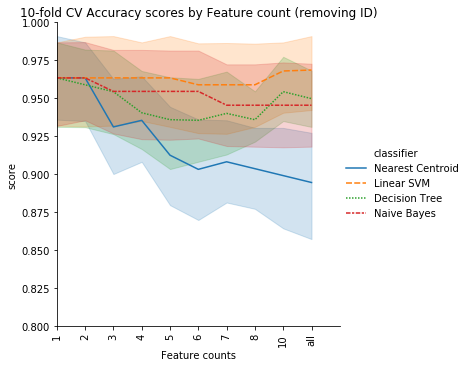

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(x="x", y="score", kind="line", hue="classifier", style="classifier", data=df_trace)
plt.xticks(range(len(feature_counts)), feature_counts, rotation='vertical')
plt.xlabel("Feature counts")
plt.title("10-fold CV Accuracy scores by Feature count (removing ID)")
axes = plt.gca()
axes.set_ylim([0.8,1.0])
axes.set_xlim([0,len(feature_counts)])
plt.savefig('congress_feature_cnt_eval_wo_id.pdf')
plt.show()

In [85]:
import plotly.io as pio
traces = []
for clf_name in names:
    traces.append(go.Box(
        y=cl_scores[clf_name]['test_acc'],
        boxpoints='all',
        name=clf_name
    ))
    
layout = go.Layout(title="Accuracy on Test Set (Congressional Voting)")
fig=go.Figure(data=traces, layout=layout)
py.iplot(fig)
pio.write_image(fig, 'boxplots_congress.pdf')



OSError: [Errno 22] Invalid argument: 'boxplots_congress.pdf'

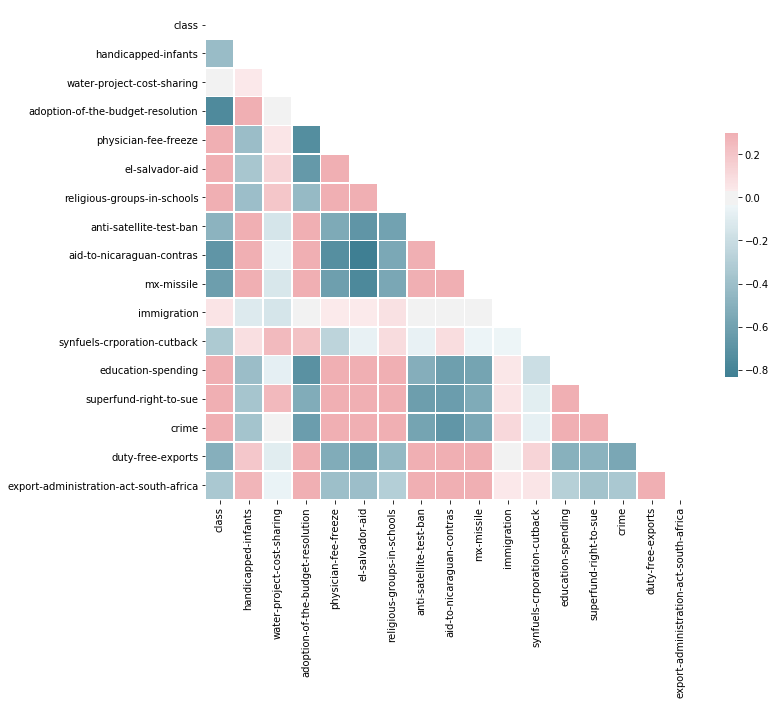

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
df_cor = df_train.replace({True:1, False:0})
df_cor['class'] = np.where(df_cor['class']=='republican',1.0,0.0)
df_cor = df_cor.drop('ID', axis=1)
corr = df_cor.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('congress_heatmap.pdf')
plt.show()

In [22]:
df_cor

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,134,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,224,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,32,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
3,171,1,1.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,1.0,NaN,0.0,0.0,0.0,0.0,1.0,NaN
4,333,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
5,148,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
6,83,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
7,24,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,281,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
9,416,1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
import sklearn
sklearn.__version__

'0.20.1'

0 --- 1e-05
[0.62222222 0.63636364 0.62790698 0.62790698 0.62790698]
1 --- 0.0001
[0.62222222 0.63636364 0.62790698 0.62790698 0.62790698]
2 --- 0.001
[0.62222222 0.63636364 0.62790698 0.62790698 0.62790698]
3 --- 0.01
[0.88888889 0.86363636 0.95348837 0.95348837 0.90697674]
4 --- 0.1
[0.93333333 0.93181818 0.97674419 0.95348837 0.97674419]
5 --- 1
[0.93333333 0.93181818 0.97674419 0.95348837 1.        ]
6 --- 10
[0.91111111 0.97727273 0.95348837 0.93023256 1.        ]
7 --- 100
[0.91111111 0.97727273 0.93023256 0.93023256 0.93023256]
8 --- 1000
[0.91111111 0.95454545 0.95348837 0.93023256 0.90697674]


C:\Users\Mathias\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



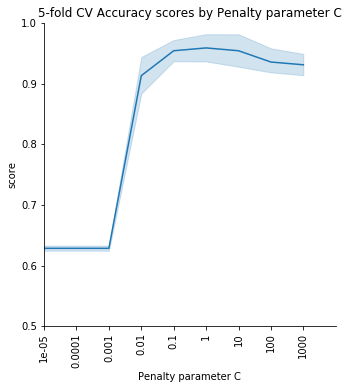

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import LinearSVC

df_vars = df_train.loc[:, df_train.columns != 'class']
df_class = df_train['class']

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_vars)
df_vars = imp.transform(df_vars)

C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []
for idx, c in enumerate(C):
    print(idx, "---", c)
    clf = SVC(kernel="linear",C=c)
    scores = cross_validate(clf, df_vars, df_class, cv=5)['test_score']
    print(scores)
    for score in scores:
        results.append({'score': score, 'x':idx, 'penalty':c})

df_trace = pd.DataFrame.from_dict(results)
g = sns.relplot(x="x", y="score", kind="line", data=df_trace)
plt.xticks(range(len(C)), C, rotation='vertical')
plt.xlabel("Penalty parameter C")
plt.title("5-fold CV Accuracy scores by Penalty parameter C")
axes = plt.gca()
axes.set_ylim([0.5,1])
axes.set_xlim([0,len(C)])
plt.savefig('scaled_congress_C_eval.pdf')
plt.show()

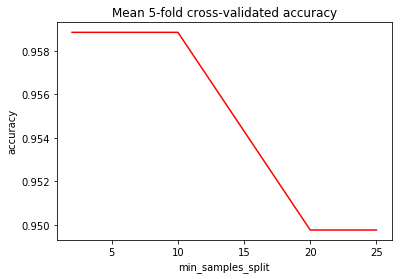

In [225]:
min_samples_splits = [2,3,4,5,7,10,15,20,25]
results = []
for min_samples_split in min_samples_splits:
    clf = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_validate(clf, df_vars, df_class, cv=10)
    results.append(scores['test_score'].mean())
    
plt.plot(min_samples_splits, results, "r", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("min_samples_split")
plt.title("Mean 5-fold cross-validated accuracy")
plt.show()